## Assignment 1 Part 2
### Name:
### Roll Number:

In [837]:
# importing all the necessary libraries
# pandas for reading the csv file, numpy for mathematical operations, matplotlib for plotting the data
import numpy as np
import pandas as pd
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import math
from pprint import pprint

In [838]:
# extracting the data from the csv file, checking the shape of the data
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape)

# randomizing the dataset
df = df.sample(frac=1).reset_index(drop=True)

print("First 5 rows of the dataset:")
df.head()

(768, 9)
First 5 rows of the dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,114,80,34,285,44.2,0.167,27,0
1,2,112,66,22,0,25.0,0.307,24,0
2,0,125,68,0,0,24.7,0.206,21,0
3,8,112,72,0,0,23.6,0.840,58,0
4,3,158,70,30,328,35.5,0.344,35,1


In [839]:
# splitting the dataset into training and testing data
# train set: 80%, test set: 20%
# validation set: 30% of the training set
train = df.iloc[:int(0.8*len(df)), :]
test = df.iloc[int(0.8*len(df)):, :]
validation = train.iloc[int(0.7*len(train)):, :]



# check the shape of the data
print("Shape of the training data:", train.shape)
print("Shape of the testing data:", test.shape)

# get the list of all the attributes
attributes = df.columns.tolist()[:-1]
print("Attributes:", attributes)

Shape of the training data: (614, 9)
Shape of the testing data: (154, 9)
Attributes: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [840]:
# create a class for the decision tree

class Node:
    def __init__(self, attribute=None, value=None, outcome=None, num_samples=None):
        self.attribute = attribute 
        self.value = value
        self.outcome = outcome
        self.num_samples = num_samples
        self.children = {}
        
def get_entropy(data):
    if len(data) == 0:
        return 0
    p = sum(data['Outcome']) / len(data)
    n = 1 - p
    if p == 0 or n == 0:
        return 0
    return -p * math.log(p, 2) - n * math.log(n, 2)

def get_information_gain(data, attribute, threshold):
    l = data[data[attribute] <= threshold]
    r = data[data[attribute] > threshold]
    
    total_entropy = get_entropy(data)
    l_entropy = get_entropy(l)
    r_entropy = get_entropy(r)
    return total_entropy - (len(l) / len(data)) * l_entropy - (len(r) / len(data)) * r_entropy

def get_best_split(data, attributes):
    best_attribute = None
    best_threshold = None
    best_gain = -1
    
    for attribute in attributes:
        if attribute == 'Outcome':
            continue
        values = data[attribute].unique()
        for value in values:
            gain = get_information_gain(data, attribute, value)
            if gain > best_gain:
                best_attribute = attribute
                best_threshold = value
                best_gain = gain
                
    return best_attribute, best_threshold

def id3(data, attributes, depth=0, MAX_DEPTH=10):
    outcomes = data['Outcome'].unique()
    if len(outcomes) == 1:
        return Node(outcome=outcomes[0], num_samples=len(data))
    if len(attributes) == 1 or depth >= MAX_DEPTH or len(data) <= 10:
        return Node(outcome=data['Outcome'].mode()[0], num_samples=len(data))
    
    best_attribute, best_threshold = get_best_split(data, attributes)
    if best_attribute is None:
        return Node(outcome=data['Outcome'].mode()[0], num_samples=len(data))
    
    node = Node(attribute=best_attribute, value=best_threshold)
    attributes.remove(best_attribute)
    
    l = data[data[best_attribute] <= best_threshold]
    r = data[data[best_attribute] > best_threshold]
    
    node.children['<='] = id3(l, attributes.copy(), depth + 1, MAX_DEPTH)
    node.children['>'] = id3(r, attributes.copy(), depth + 1, MAX_DEPTH)
    
    return node

def print_tree(node, depth=0):
    if node.outcome is not None:
        print("  " * depth + "Outcome:", node.outcome)
    else:
        print("  " * depth + f"Attribute {node.attribute} <= {node.value}:")
        print_tree(node.children['<='], depth + 1)
        print("  " * depth + f"Attribute {node.attribute} > {node.value}:")
        print_tree(node.children['>'], depth + 1)

In [841]:
tree = id3(train, attributes.copy())
# print_tree(tree)

In [842]:
def predict(node, row):
    if node.outcome is not None:
        return node.outcome
    if row[node.attribute] <= node.value:
        return predict(node.children['<='], row)
    else:
        return predict(node.children['>'], row)
    
def get_predictions(node, data):
    predictions = []
    for idx, row in data.iterrows():
        predictions.append(predict(node, row))
    return predictions

def get_accuracy(predictions, actual):
    correct = 0
    for i in range(len(predictions)):
        if predictions[i] == actual[i]:
            correct += 1
    return correct / len(predictions)

predictions = get_predictions(tree, test)
actual = test['Outcome'].tolist()
accuracy = get_accuracy(predictions, actual)
print("Accuracy:", accuracy)



Accuracy: 0.7337662337662337


Maximum accuracy: 0.7402597402597403 for MAX_DEPTH = 4


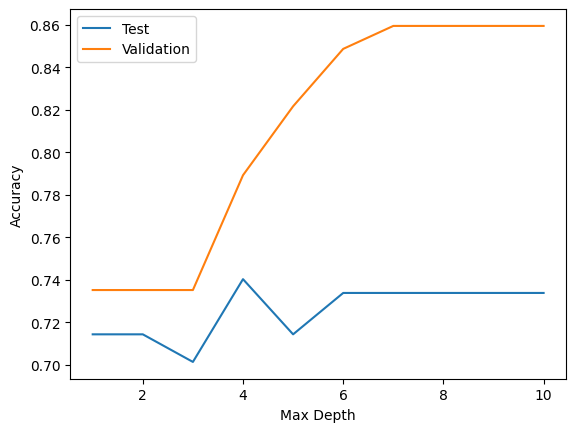

In [843]:
# now get a list of accuracies for different values of MAX_DEPTH and plot them to see how the accuracy changes with the depth of the tree
# store the value of MAX_DEPTH for which the accuracy is maximum

accuracies_test = []
accuracies_validation = []
max_depth = 0
max_accuracy = 0
for i in range(1, 11):
    tree = id3(train, attributes.copy(), MAX_DEPTH=i)
    predictions = get_predictions(tree, test)
    actual = test['Outcome'].tolist()
    accuracy = get_accuracy(predictions, actual)
    accuracies_test.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_depth = i
        
    predictions = get_predictions(tree, validation)
    actual = validation['Outcome'].tolist()
    accuracy = get_accuracy(predictions, actual)
    accuracies_validation.append(accuracy)
    
print("Maximum accuracy:", max_accuracy, "for MAX_DEPTH =", max_depth)

plt.plot(range(1, 11), accuracies_test, label='Test')
plt.plot(range(1, 11), accuracies_validation, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [844]:
def get_html_label(node):
    if node.outcome is not None:
        return f'<b>Outcome:</b> <br/> {node.outcome}'
    else:
        attribute_name = node.attribute.replace('_', ' ').title()  # Replace underscores and title case
        label = f'<b>{attribute_name}</b><br/>{node.value:.2f}'
        return label

def get_dot(node, parent_id='', edge_label='', dot='', node_count=0):
    node_id = node_count
    node_count += 1
    
    label = get_html_label(node)
    dot += f'N{node_id} [label=<{label}>, shape=box];\n'
    
    if parent_id != '':
        dot += f'N{parent_id} -> N{node_id} [label="{edge_label}"];\n'
    
    if node.attribute is not None:
        dot, node_count = get_dot(node.children['<='], node_id, '<=', dot, node_count)
        dot, node_count = get_dot(node.children['>'], node_id, '>', dot, node_count)
        
    return dot, node_count

# Generate the DOT representation of the decision tree
dot_representation = generate_dot(tree)

# Save the DOT representation to a file
with open('decision_tree.dot', 'w') as dot_file:
    dot_file.write(dot_representation)


In [845]:
# get original accuracy

# pruning the tree
# Consider each node for pruning
# Pruning = removing the subtree at that node, make it a leaf and assign the most common class at that node
# A node is removed if the resulting tree performs no worse then the original on the test set - removes coincidences and errors
# Nodes are removed iteratively choosing the node whose removal most increases the decision tree accuracy on the graph
# Pruning continues until further pruning is harmful
# uses training, test & test sets - effective approach if a large amount of data is available
# follow above algo

# reduced error pruning
# start at the leaves and work upwards towards the root
# at each node, remove the subtree if the resulting tree performs no worse than the original on the test set
# repeat until further pruning is harmful



def bottom_up_pruning(node, data):
    if node.outcome is None:
        if node.children['<='].outcome is None:
            bottom_up_pruning(node.children['<='], data)
        if node.children['>'].outcome is None:
            bottom_up_pruning(node.children['>'], data)

        if node.children['<='].outcome is not None and node.children['>'].outcome is not None:
            # Calculate accuracy of the subtree on the test set
            predictions = get_predictions(node, data)
            actual = data['Outcome'].tolist()
            accuracy = get_accuracy(predictions, actual)

            # Calculate accuracy if the subtree was pruned (both children have outcomes)
            if node.children['<='].num_samples is not None and node.children['>'].num_samples is not None:
                if node.children['<='].num_samples > node.children['>'].num_samples:
                    outcome = node.children['<='].outcome
                else:
                    outcome = node.children['>'].outcome
                predictions = [outcome] * len(data)
                accuracy_pruned = get_accuracy(predictions, actual)

                # If pruned accuracy is better, then prune the subtree
                if accuracy_pruned >= accuracy:
                    node.outcome = outcome
                    # node.num_samples = node.children['<='].num_samples + node.children['>'].num_samples
                    node.children = {}

tree = id3(train, attributes.copy(), MAX_DEPTH=2)
pruned_tree = tree

# Apply bottom-up pruning to the cloned tree
bottom_up_pruning(pruned_tree, validation)

# Get the accuracy of the pruned tree
predictions_pruned = get_predictions(pruned_tree, test)
actual = test['Outcome'].tolist()
accuracy_pruned = get_accuracy(predictions_pruned, actual)
print("Pruned Tree Accuracy:", accuracy_pruned)

# Get the accuracy of the original tree
predictions_original = get_predictions(tree, test)
actual = test['Outcome'].tolist()
accuracy_original = get_accuracy(predictions_original, actual)
print("Original Tree Accuracy:", accuracy_original)

if pruned_tree == tree:
    print("Pruned tree is same as original tree")


    



Pruned Tree Accuracy: 0.7142857142857143
Original Tree Accuracy: 0.7142857142857143
Pruned tree is same as original tree
